In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Blurry image detection function
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

template_folder = "/content/gdrive/MyDrive/Image processing/LPR Project/temps"
test_folder = "/content/gdrive/MyDrive/Image processing/LPR Project/test_plates"
output_csv = "/content/gdrive/MyDrive/Image processing/LPR Project/LPR_results.csv"

In [ ]:
#BLOCK 1

def preprocess_template(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Remove noise
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # Adaptive threshold + OTSU
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 10
    )
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary = cv2.bitwise_or(thresh, otsu)

    # Morphological cleanup
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))

    # Find tight bounding box
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)
    crop = binary[y:y+h, x:x+w]

    # Resize to 32x32 with padding
    h_c, w_c = crop.shape
    if h_c > w_c:
        pad = (h_c - w_c) // 2
        crop = cv2.copyMakeBorder(crop, 0, 0, pad, h_c-w_c-pad, cv2.BORDER_CONSTANT, value=0)
    else:
        pad = (w_c - h_c) // 2
        crop = cv2.copyMakeBorder(crop, pad, w_c-h_c-pad, 0, 0, cv2.BORDER_CONSTANT, value=0)

    resized = cv2.resize(crop, (32,32))

    # Dilation: normalize strokes (templates)
    norm = cv2.dilate(resized, np.ones((2,2), np.uint8), iterations=1)

    return norm


def extract_hog(img):
    return hog(
        img,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        visualize=False
    )

def load_templates(template_folder):
    template_hogs = []
    template_names = []
    template_imgs = []

    for filename in sorted(os.listdir(template_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            path = os.path.join(template_folder, filename)
            label = os.path.splitext(filename)[0]  # Extract label from filename

            # Remove trailing underscore
            if "_" in label and label.split("_")[-1].isdigit():
                label = "_".join(label.split("_")[:-1])

            img = cv2.imread(path)
            processed = preprocess_template(img)
            hog_vec = extract_hog(processed)

            template_hogs.append(hog_vec)
            template_names.append(label)
            template_imgs.append(processed)

    return np.array(template_hogs), template_names, template_imgs


In [ ]:
# -----------------------------
# Preprocess test plate BLOCK 2
# -----------------------------

def preprocess_plate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray) #Contrast Limited Adaptive Histogram Equalization to improve local contrast

    if is_blurry(gray):
        kernel = np.array([[0, -1, 0], [-1, 5, -1],[0,-1,0]])
        gray = cv2.filter2D(gray, -1, kernel)

    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 31, 10)
    _, otsu = cv2.threshold(gray,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary = cv2.bitwise_or(adaptive, otsu)

    # Morph cleanup
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Show for debug
    show_final_preprocessed_plate(image, binary, title=f"Final Preprocessed Plate ({test_folder})")
    return binary

# Character segmentation
def extract_characters(binary_plate_img):
    H, W = binary_plate_img.shape[:2]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    clean = cv2.morphologyEx(binary_plate_img, cv2.MORPH_CLOSE, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean, connectivity=8)

    char_regions, characters, bboxes = [], [], []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        aspect = h / max(w,1)
        area_ratio = area / (H*W)
        if (0.30*H < h < 0.98*H and 0.02*W < w < 0.35*W and 0.25<aspect<6.0 and area_ratio>0.001):
            char_regions.append((x,y,w,h))
    char_regions = sorted(char_regions, key=lambda r:r[0])

    for (x,y,w,h) in char_regions:
        char_img = binary_plate_img[y:y+h, x:x+w]
        char_img = cv2.resize(char_img,(32,32))
        char_img = cv2.dilate(char_img,np.ones((2,2),np.uint8),iterations=1)
        characters.append(char_img)
        bboxes.append((x,y,w,h))
    return characters, bboxes


# Match character using Chi-square distance
def match_character(char_hog, template_hogs, template_names):
    # Compute chi-square distances
    eps = 1e-10
    distances = np.array([0.5*np.sum((char_hog - t)**2/(char_hog + t + eps)) for t in template_hogs])
    best_idx = np.argmin(distances)
    return template_names[best_idx], distances[best_idx]



# Visualization
def show_templates(template_imgs, template_names):
    plt.figure(figsize=(16,4))
    for i, img in enumerate(template_imgs):
        plt.subplot(2,len(template_imgs)//2+1,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(template_names[i])
        plt.axis("off")
    plt.show()


def visualize_plate(image, bboxes, labels):
    img_copy = image.copy()
    for (x,y,w,h), label in zip(bboxes, labels):
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(img_copy,label,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,0,0),2)
    cv2_imshow(img_copy)


In [ ]:
import gc #Memory cleanup
def refine_ambiguous_character(char_img, hog_label):

    # Ensure binary
    _, bw = cv2.threshold(char_img, 127, 255, cv2.THRESH_BINARY)

    # Connected Components (foreground)
    num_cc, _, _, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
    C = num_cc - 1  # exclude background

    # Holes (invert image)
    inv = cv2.bitwise_not(bw)
    num_holes, _, _, _ = cv2.connectedComponentsWithStats(inv, connectivity=8)
    H = num_holes - 1  # exclude background

    # Euler number
    E = C - H

    # Aspect ratio
    h, w = bw.shape
    aspect_ratio = h / max(w, 1)

    # -------------------------
    # 8 ↔ B
    # -------------------------
    if hog_label in ("8", "B"):
        # Both have 2 holes, distinguish by shape
        if H == 2:
            if aspect_ratio > 1.3:
                return "B"
            else:
                return "8"


    # -------------------------
    # 5 ↔ 6
    # -------------------------
    if hog_label in ("5", "6"):
        # 6 has one hole, 5 has none
        if H == 1:
            return "6"
        else:
            return "5"



    return hog_label


# Main recognition function BLOCK 3
def recognize_plates():
    template_hogs, template_names, template_imgs = load_templates(template_folder)
    results = []

    for filename in sorted(os.listdir(test_folder)):
        if not filename.lower().endswith((".png",".jpg",".jpeg",".bmp")):
            continue

        print("\n======================================")
        print("Processing:", filename)

        image_path = os.path.join(test_folder, filename)
        image = cv2.imread(image_path)

        if image is None:
            print("\u274c Failed to load image")
            continue

        # --- Preprocess plate ---
        binary = preprocess_plate(image)

        # --- Character segmentation ---
        chars, bboxes = extract_characters(binary)

        recognized_labels = []
        scores = []

        USE_TOPOLOGY_REFINEMENT = False

        for ch in chars:
            hog_vec = extract_hog(ch)
            label, score = match_character(hog_vec, template_hogs, template_names)

            if USE_TOPOLOGY_REFINEMENT and label in {"8","B","C","G","5","6","1","L"}:
                label = refine_ambiguous_character(ch, label)

            recognized_labels.append(label)
            scores.append(score)


        plate_text = "".join(recognized_labels)


        print(f"Recognized Plate: {plate_text}")

        results.append([filename, plate_text])

        # --- Visualization ---
        vis_img = image.copy()
        for (x,y,w,h), lbl in zip(bboxes, recognized_labels):
            cv2.rectangle(vis_img, (x,y), (x+w,y+h), (0,255,0), 2)
            cv2.putText(vis_img, lbl, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        plt.figure(figsize=(10,3))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{filename} → {plate_text}")
        plt.axis("off")
        plt.show()

        #Memory cleanup
        del image, binary, vis_img, chars, bboxes
        gc.collect()



    #Save outputs to CSV
    df = pd.DataFrame(results, columns=["filename", "recognized_text"])
    df.to_csv(output_csv, index=False)
    print("\n\u2705 CSV saved to:", output_csv)

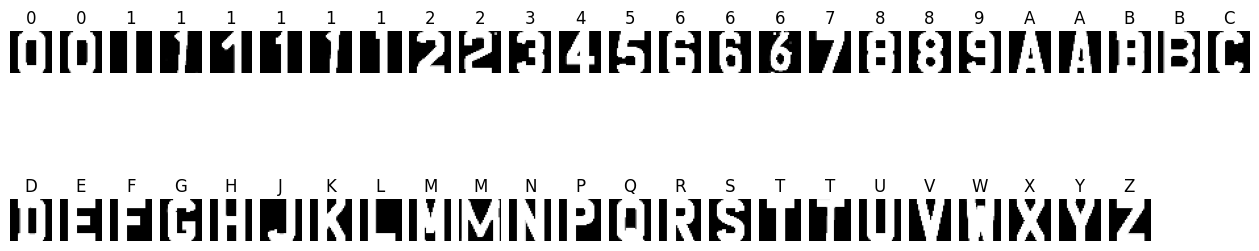

In [ ]:

#Show templates after preprocessing
template_hogs, template_names, template_imgs = load_templates(template_folder)
show_templates(template_imgs, template_names)



In [ ]:
def show_final_preprocessed_plate(original_img, final_binary, title="Preprocessed Plate"):

    plt.figure(figsize=(8,5))
    plt.imshow(final_binary, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
recognize_plates()

Output hidden; open in https://colab.research.google.com to view.